## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### First, we'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### Then, we'll calculate distortion coefficients, apply a distortion correction to raw images and test undistortion on an image

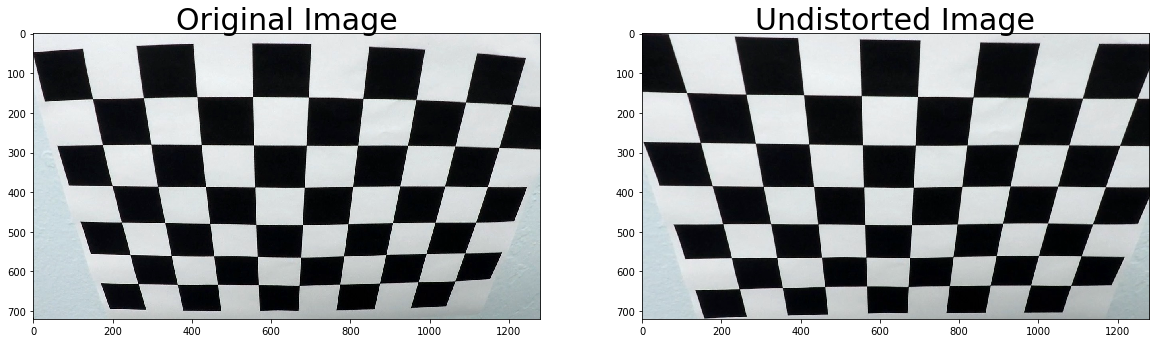

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undistored.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Now, we'll use color transforms, gradients, etc., to create a thresholded binary image.

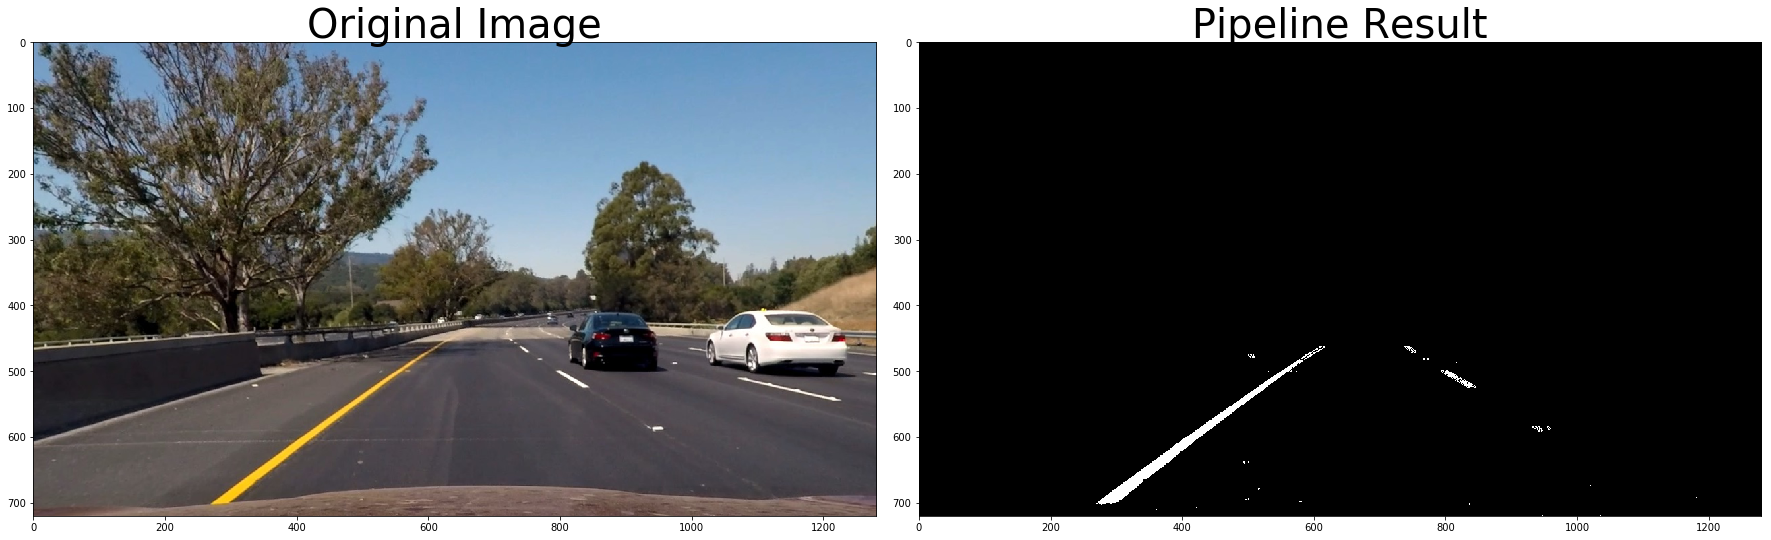

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
#objpoints = dist_pickle["objpoints"]
#imgpoints = dist_pickle["imgpoints"]
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

image = mpimg.imread('test_images/test6.jpg')

# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(image, mtx, dist):
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

undistorted = cal_undistort(image, mtx, dist)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


kernel_size = 9
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(30, 90)):
    img = np.copy(img)
    
    gray = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)  

    # apply Gaussian smoothing
    
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    
    # apply Canny 
    edges = cv2.Canny(blur_gray, 70,150)

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # apply Gaussian smoothing
    blur_s = cv2.GaussianBlur(s_channel,(kernel_size, kernel_size),0)    
    
    # Threshold color channel
    s_binary = np.zeros_like(blur_s)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)|(edges ==1)] = 1

    
    # Here we are defining a four sided polygon to mask
    imshape = img.shape
    vertices = np.array([[(50,imshape[0]),(imshape[1]/2-130, imshape[0]*3/5+30), (imshape[1]/2+130, imshape[0]*3/5+30), \
                          (imshape[1]-50,imshape[0])]], dtype=np.int32)
    combined_binary = region_of_interest(combined_binary,vertices)

    return combined_binary
    
result = pipeline(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result , cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Automatic finding points for perspective transform using the first project

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
src [[  271.   684.]
 [  469.   540.]
 [ 1050.   684.]
 [  826.   540.]]
dst [[  271.   684.]
 [  271.   540.]
 [ 1050.   684.]
 [ 1050.   540.]]


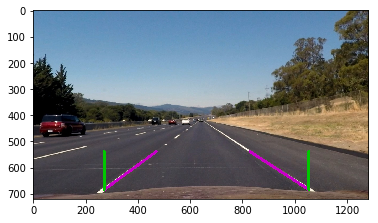

In [4]:
import matplotlib.image as mpimg
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, leftLine = np.zeros(4,dtype = int), rightLine = np.zeros(4,dtype = int), color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    slope = np.zeros(len(lines))# The slopes of all the lines
    leftLineList = []
    rightLineList = []
    for i in range (len(lines)):
        for x1,y1,x2,y2 in lines[i]:
            slope[i] = (y2-y1)/(x2-x1)
            if (abs(slope[i])>0.5):# Here we filters the horizontal lines
                #Now we sort the lines from the left side to those from the right side of the image
                if (x1 < len(img[0])*6/11 and x2 <len(img[0])*6/11):
                    leftLineList.append(lines[i])
                elif (x1 > len(img[0])*5/11 and x2 > len(img[0])*5/11):
                    rightLineList.append(lines[i])
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                
    if (len(leftLineList)>0):# Here we take the mean of the lines and we deduce the path of our left line
        A = np.mean(leftLineList,axis=0)[0]
        mA = (A[3]-A[1])/(A[2]-A[0])
        bA = (A[3]+A[1]-mA*(A[2]+A[0]))/2
        yA1 = int(len(img)*9.5/10)
        xA1 = int((yA1-bA)/mA)
        yA2 = int(len(img)*7.5/10)
        xA2 = int((yA2-bA)/mA)
        leftLine = [xA1,yA1,xA2,yA2]
        

    if (len(rightLineList)>0):# Here we take the mean of the lines and we deduce the path of our right line
        B = np.mean(rightLineList,axis=0)[0]
        mB = (B[3]-B[1])/(B[2]-B[0])
        bB = (B[3]+B[1]-mB*(B[2]+B[0]))/2
        yB1 = int(len(img)*9.5/10)
        xB1 = int((yB1-bB)/mB)
        yB2 = int(len(img)*7.5/10)
        xB2 = int((yB2-bB)/mB)
        rightLine = [xB1,yB1,xB2,yB2]
        
    cv2.line(img, (leftLine[0], leftLine[1]), (leftLine[2], leftLine[3]), color, thickness)
    cv2.line(img, (rightLine[0], rightLine[1]), (rightLine[2], rightLine[3]), color, thickness)
    
    return leftLine, rightLine # allow us to keep the old values of the line if we can't find new lines on the next images

        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)




# Define a kernel size 
kernel_size = 9
# Define our parameters for Canny 
low_threshold = 70
high_threshold = 150
# Next we'll create a masked edges image using cv2.fillPoly()  
ignore_mask_color = 255   
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 20     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments

dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"] 

image_perspective = mpimg.imread('test_images/straight_lines2.jpg')
print('This image is:', type(image_perspective), 'with dimensions:', image_perspective.shape)
image_perspective = cv2.undistort(image_perspective,mtx, dist, None, mtx)

def getCoefForBirdView(image):

    gray = grayscale(image_perspective)    

    # apply Gaussian smoothing
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    
    # apply Canny 
    edges = cv2.Canny(blur_gray, low_threshold,high_threshold)
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   

    # This time we are defining a four sided polygon to mask
    imshape = image_perspective.shape
    vertices = np.array([[(0,imshape[0]),(450, 340), (490, 340), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    line_image = np.copy(image_perspective)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    l,r = draw_lines(image_perspective, lines, color=[200,0,200], thickness=10)

    src = np.float32([[l[0],l[1]],[l[2],l[3]],[r[0],r[1]],[r[2],r[3]]])
    dst = np.float32([[l[0],l[1]],[l[0],l[3]],[r[0],r[1]],[r[0],r[3]]])
    
    return src, dst

src,dst = getCoefForBirdView(image_perspective)
cv2.line(image_perspective, (dst[0][0],dst[0][1]),(dst[1][0],dst[1][1]), [0,200,0], 10)
cv2.line(image_perspective, (dst[2][0],dst[2][1]),(dst[3][0],dst[3][1]), [0,200,0], 10)
print("src",src)
print("dst",dst)
plt.figure()
plt.imshow(image_perspective)
    


### Now, we'll test the perspective transform ("birds-eye view").

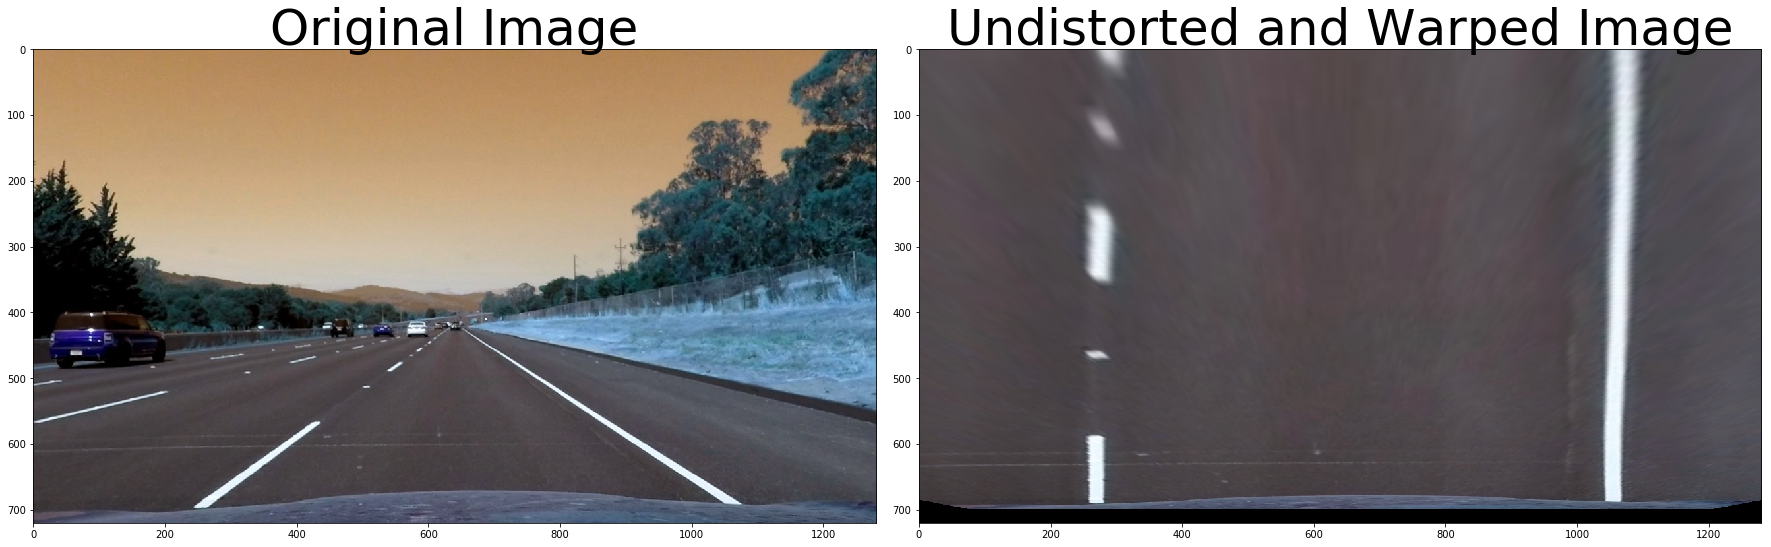

In [5]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('test_images/straight_lines2.jpg')

img = cv2.undistort(img,mtx, dist, None, mtx)

def birdView(img, src,dst):
    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

top_down, perspective_M,_ = birdView(img, src,dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Now, we'll Detect the lane boundary and determine the curvature of the lane and vehicle position with respect to center.

[ -3.02787703e-04   3.76320360e-01   2.15644879e+02]
[ -3.68888460e-04   4.55413532e-01   9.67957915e+02]


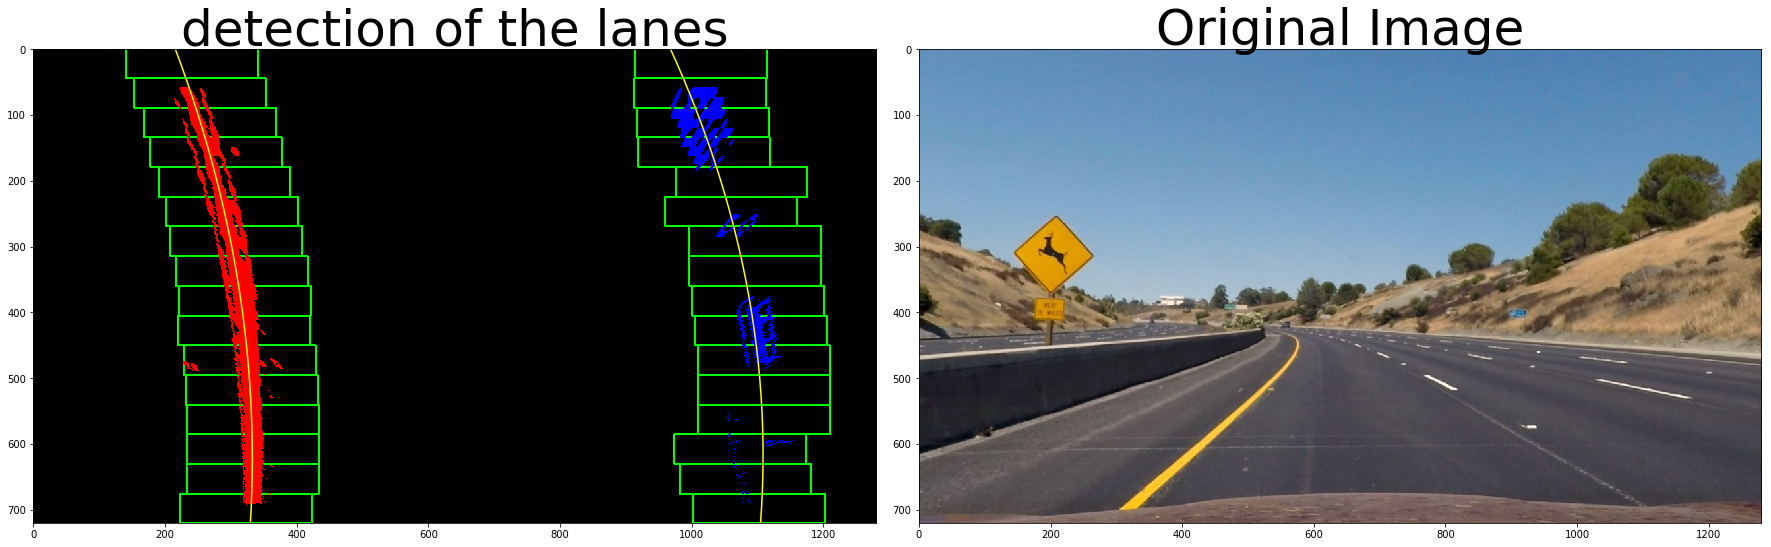

In [6]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
image = mpimg.imread('test_images/test2.jpg')
image = cv2.undistort(image,mtx, dist, None, mtx)# undistored the image
imageforProcess = pipeline(image)# define a binary image
imageforProcess, _, _ = birdView(imageforProcess,src,dst)# change the perspective of the image


#binary_warped = imageforProcess

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 16
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 30

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    


    return out_img,left_fitx, right_fitx,ploty,left_fit,right_fit


imageforProcess,left_fitx, right_fitx,ploty,left_fit,right_fit = fit_polynomial(imageforProcess)

print(left_fit)
print(right_fit)

# Plots the left and right polynomials on the lane lines
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')
ax1.imshow(imageforProcess)
ax1.set_title('detection of the lanes', fontsize=50)
ax2.imshow(image)
ax2.set_title('Original Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Skip the sliding windows step once you've found the lines

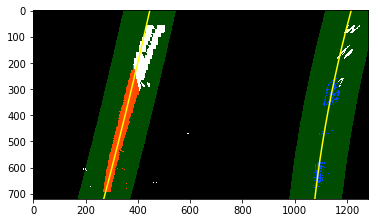

In [7]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
image = mpimg.imread('test_images/test3.jpg')
image = cv2.undistort(image,mtx, dist, None, mtx)# undistored the image
imageforProcess = pipeline(image)# define a binary image
imageforProcess, _ , _= birdView(imageforProcess,src,dst)# change the perspective of the image
#imageforProcess,left_fit,right_fit,ploty = fit_polynomial(imageforProcess)

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ -3.18304754e-04,   3.91045785e-01,   2.13153011e+02])
right_fit = np.array([-3.28258976e-06,   2.57916601e-01,   9.89070456e+02])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty,left_fit,right_fit

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    #global left_fit, right_fit
    left_fitx, right_fitx, ploty,new_left_fit,new_right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

    #left_fit = new_left_fit
    #right_fit = new_right_fit
    
    return result,left_fitx, right_fitx,ploty,new_left_fit,new_right_fit

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
imageforProcess,left_fitx, right_fitx,ploty,left_fit,right_fit = search_around_poly(imageforProcess)

# View your output
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(imageforProcess)




### here we create a function to decide wich function use between 'fit_polynomial' and 'search_around_poly'

In [8]:
accu = 0

def define_poly(imageforProcess):
    global lost_lane,accu,left_fit_array,right_fit_array
    
    # il va falloir normaliser ces deux fonctions
    if (accu == 0%12):
        imageforProcess2,left_fitx2, right_fitx2,ploty2,left_fit2,right_fit2 = fit_polynomial(imageforProcess)
        accu = 0

    else :
        imageforProcess2,left_fitx2, right_fitx2,ploty2,left_fit2,right_fit2 = search_around_poly(imageforProcess)
        for i in range (int(len(ploty)/50)):
            if ((abs(right_fitx[i*50]-left_fitx[i*50])<450)or((right_fitx[i*50]-left_fitx[i*50])>1000)):
                imageforProcess2,left_fitx2, right_fitx2,ploty2,left_fit2,right_fit2 = fit_polynomial(imageforProcess)
                accu = 0

    accu +=1
    
    return imageforProcess2,left_fitx2, right_fitx2,ploty2,left_fit2,right_fit2




### Now, we'll add the green area between the lane lines on the original image

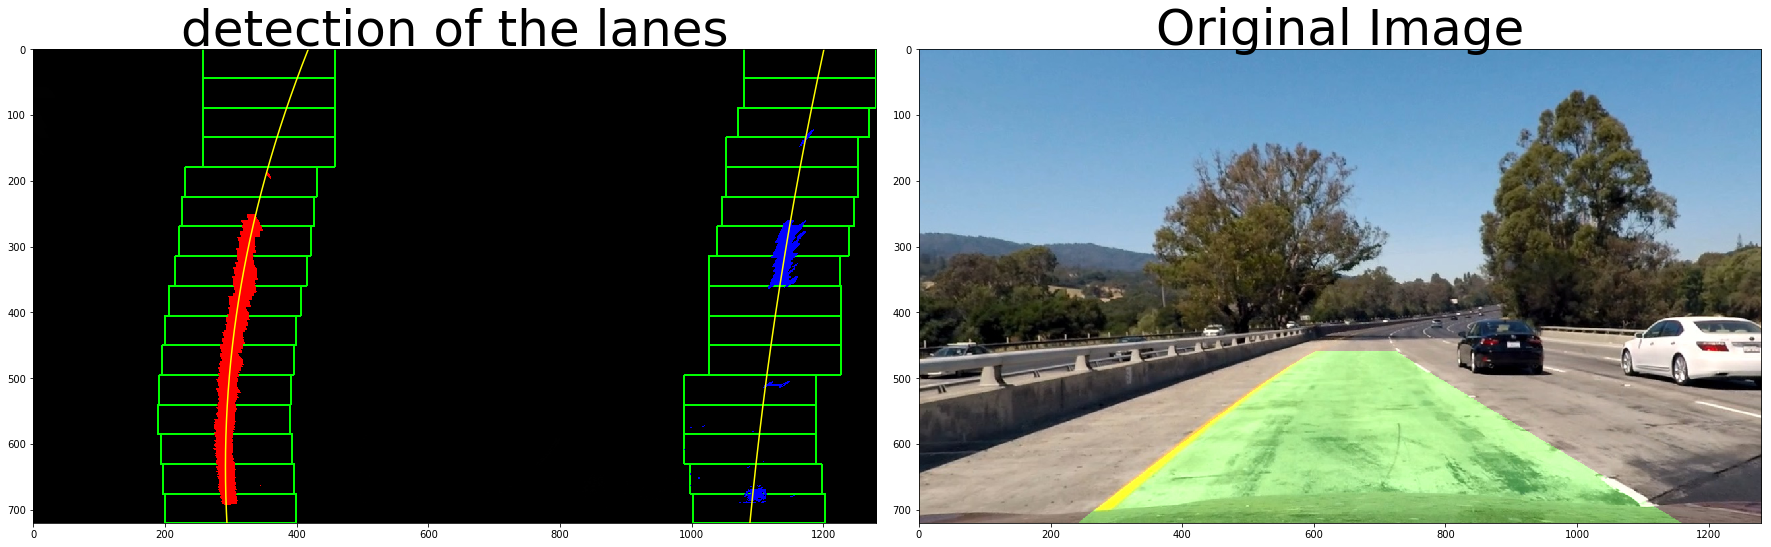

In [9]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
image = mpimg.imread('test_images/test1.jpg')
image = cv2.undistort(image,mtx, dist, None, mtx)# undistored the image
imageforProcess = pipeline(image)# define a binary image
imageforProcess, _, _ = birdView(imageforProcess,src,dst)# change the perspective of the image
imageforProcess,left_fitx, right_fitx,ploty,left_fit,right_fit = define_poly(imageforProcess)

# use cv2.getPerspectiveTransform() to get M, the transform matrix
Minv = cv2.getPerspectiveTransform(dst, src)

def render_lanes( image, Minv, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ptsL = np.vstack((left_fitx,ploty)).astype(np.int32).T
    ptsR = np.vstack((right_fitx,ploty)).astype(np.int32).T
    pts = np.concatenate((ptsL,np.flipud(ptsR)))
    # Draw the lane onto the warped blank image
    #plt.plot(left_fitx, ploty, color='yellow')
    cv2.polylines(color_warp,  [pts],  False,  (0, 255, 0),  10)
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    

    
    return result,color_warp, pts

final,color_warp, pts = render_lanes(image, Minv, left_fitx, right_fitx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')
ax1.imshow(imageforProcess, cmap='gray')
ax1.set_title('detection of the lanes', fontsize=50)
ax2.imshow(final)
ax2.set_title('Original Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Now we'll mesure the curvature of the lane lines

In [10]:
left_curverad_array = np.zeros(5)
right_curverad_array = np.zeros(5)



def mesure_curvature(left_fit,right_fit,ploty, left_fitx, right_fitx):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/(1050-350) # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
 
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    for i in range(len(left_curverad_array)-1):#to keep the last five values of the curvatures
        left_curverad_array[i] = left_curverad_array[i+1]
        right_curverad_array[i] = right_curverad_array[i+1]
        
    left_curverad_array[-1] = left_curverad
    right_curverad_array[-1] = right_curverad
    
    left_curverad_avg = np.mean(left_curverad_array)
    right_curverad_avg = np.mean(right_curverad_array)
    
    #calcul distance to the center
    dist_center = (left_fitx[y_eval] + right_fitx[y_eval]- image.shape[1])/2*xm_per_pix
    

    
    return int((left_curverad_avg+right_curverad_avg)/2), int(100*dist_center)/100


#Calculate the radius of curvature in meters for both lane lines
#left_curverad, right_curverad = mesure_curvature(left_fit,right_fit,ploty)




## Test on Video

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

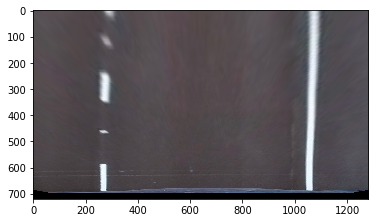

In [12]:
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

img2 = cv2.imread('test_images/straight_lines2.jpg')
img2 = cv2.undistort(img2,mtx, dist, None, mtx)
#src,dst = getCoefForBirdView(img2)
img2, perspective_M,_ = birdView(img2, src,dst)
plt.figure
plt.imshow(img2)


accu = 0

### Function for processing one image

In [13]:
def process_image(image):
    global left_fit, right_fit
    image = cv2.undistort(image,mtx, dist, None, mtx)# undistored the image
    imageforProcess = pipeline(image)# define a binary image

    imageforProcess, _,Minv = birdView(imageforProcess,src,dst)# change the perspective of the image
    imageforProcess,left_fitx, right_fitx,ploty,left_fit,right_fit = define_poly(imageforProcess)
    #plt.figure()
    #plt.imshow(imageforProcess,cmap='gray')
    image,color_warp, pts = render_lanes(image, Minv, left_fitx, right_fitx)
    #mesure the curvature
    curverad, dist_center = mesure_curvature(left_fit,right_fit,ploty,left_fitx, right_fitx)
    
    cv2.putText(image,"curverad : " + str(curverad)+"m", (10,50), cv2.FONT_HERSHEY_COMPLEX, 1, 0)
    cv2.putText(image,"distance from center : " +str(dist_center)+"m", (10,100), cv2.FONT_HERSHEY_COMPLEX, 1, 0)
    

    
    return image

### Simplest video

In [14]:
accu = 0

white_output = 'test_video_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(34,50)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_video_output/project_video.mp4.
Moviepy - Writing video test_video_output/project_video.mp4



Moviepy - Done !
Moviepy - video ready test_video_output/project_video.mp4
Wall time: 6min 43s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Challenge Video

In [16]:
accu = 0

white_output = 'test_video_output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")#.subclip(0,3)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_video_output/challenge_video.mp4.
Moviepy - Writing video test_video_output/challenge_video.mp4



Moviepy - Done !
Moviepy - video ready test_video_output/challenge_video.mp4
Wall time: 2min 38s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Harder Challenge Video

In [18]:
accu = 0

white_output = 'test_video_output/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")#.subclip(0,3)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_video_output/harder_challenge_video.mp4.
Moviepy - Writing video test_video_output/harder_challenge_video.mp4



Moviepy - Done !
Moviepy - video ready test_video_output/harder_challenge_video.mp4
Wall time: 6min 32s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))